# Overfit-generalization-underfit

In the previous notebook, we presented the general cross-validation framework
and how it helps us quantify the training and testing errors as well as their
fluctuations.

In this notebook, we put these two errors into perspective and show how they
can help us know if our model generalizes, overfits, or underfits.

Let's first load the data and create the same model as in the previous
notebook.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [2]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

## Overfitting vs. underfitting

To better understand the generalization performance of our model and maybe
find insights on how to improve it, we compare the testing error with the
training error. Thus, we need to compute the error on the training set, which
is possible using the `cross_validate` function.

In [3]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv_results = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=2,
)
cv_results = pd.DataFrame(cv_results)

In [4]:
cv_results

,fit_time,score_time,test_score,train_score
0,0.179867,0.003419,-47.192965,-1.556722e-14
1,0.180198,0.003255,-47.402738,-3.256654e-15
2,0.168324,0.002769,-44.797475,-9.263907e-15
3,0.168594,0.003113,-43.574799,-3.645663e-15
4,0.159455,0.005029,-47.445247,-8.833588e-15
5,0.155339,0.004624,-44.879184,-1.260663e-14
6,0.163968,0.004316,-44.378575,-1.440708e-14
7,0.163068,0.004257,-44.415350,-3.711071e-15
8,0.162438,0.005010,-45.227269,-1.117452e-14
9,0.168228,0.005261,-45.224024,-3.421897e-15


The cross-validation used the negative mean absolute error. We transform the
negative mean absolute error into a positive mean absolute error.

In [5]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]
]

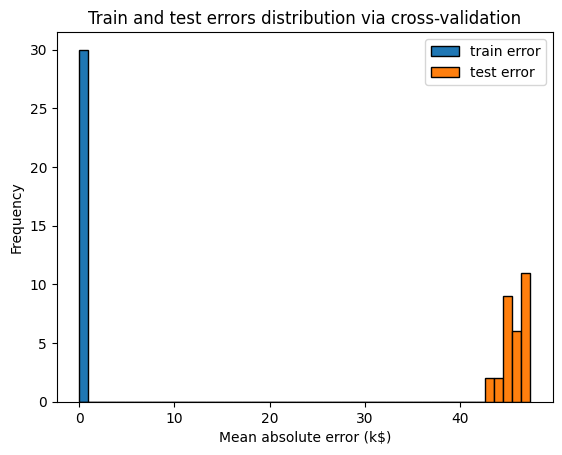

In [6]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

By plotting the distribution of the training and testing errors, we get
information about whether our model is over-fitting, under-fitting (or both at
the same time).

Here, we observe a **small training error** (actually zero), meaning that the
model is **not under-fitting**: it is flexible enough to capture any
variations present in the training set.

However the **significantly larger testing error** tells us that the model is
**over-fitting**: the model has memorized many variations of the training set
that could be considered "noisy" because they do not generalize to help us
make good prediction on the test set.

## Validation curve

We call **hyperparameters** those parameters that potentially impact the
result of the learning and subsequent predictions of a predictor. For example:

- the number of neighbors in a k-nearest neighbor model;

- the degree of the polynomial.

Some model hyperparameters are usually the key to go from a model that
underfits to a model that overfits, hopefully going through a region were we
can get a good balance between the two. We can acquire knowledge by plotting a
curve called the validation curve. This curve can also be applied to the above
experiment and varies the value of a hyperparameter.

For the decision tree, the `max_depth` hyperparameter is used to control the
tradeoff between under-fitting and over-fitting.

CPU times: total: 297 ms
Wall time: 13.7 s


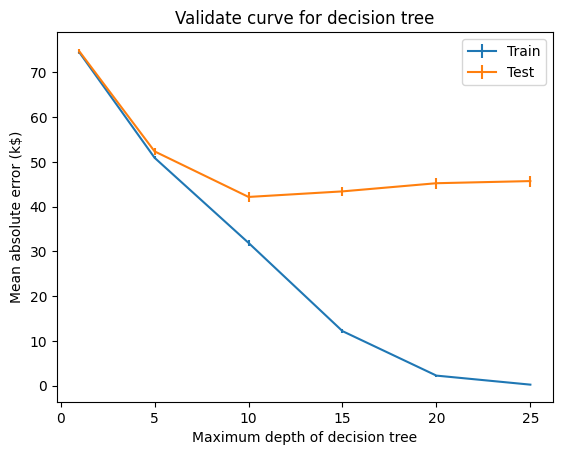

In [14]:
%%time
import numpy as np
from sklearn.model_selection import ValidationCurveDisplay

max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    param_name="max_depth",
    param_range=max_depth,
    cv=cv,
    scoring="neg_mean_absolute_error",
    negate_score=True,
    std_display_style="errorbar",
    n_jobs=2,
)
_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="Mean absolute error (k$)",
    title="Validate curve for decision tree",
)

The validation curve can be divided into three areas:

- For `max_depth < 10`, the decision tree underfits. The training error and
  therefore the testing error are both high. The model is too constrained and
  cannot capture much of the variability of the target variable.

- The region around `max_depth = 10` corresponds to the parameter for which
  the decision tree generalizes the best. It is flexible enough to capture a
  fraction of the variability of the target that generalizes, while not
  memorizing all of the noise in the target.

- For `max_depth > 10`, the decision tree overfits. The training error becomes
  very small, while the testing error increases. In this region, the models
  create decisions specifically for noisy samples harming its ability to
  generalize to test data.

Note that for `max_depth = 10`, the model overfits a bit as there is a gap
between the training error and the testing error. It can also potentially
underfit also a bit at the same time, because the training error is still far
from zero (more than 30 k\\$), meaning that the model might still be too
constrained to model interesting parts of the data. However, the testing error
is minimal, and this is what really matters. This is the best compromise we
could reach by just tuning this parameter.

Be aware that looking at the mean errors is quite limiting. We should also
look at the standard deviation to assess the dispersion of the score. For such
purpose, we can use the parameter `std_display_style` to show the standard
deviation of the errors as well. In this case, the variance of the errors is
small compared to their respective values, and therefore the conclusions above
are quite clear. This is not necessarily always the case.

## Summary:

In this notebook, we saw:

* how to identify whether a model is generalizing, overfitting, or
  underfitting;
* how to check influence of a hyperparameter on the underfit/overfit tradeoff.